In [1]:
import math
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from syspy.skims import skims

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves price and accessibility attribute to PT LoS table
## Needs PT LoS table and links

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
los = stepmodel.read_json(model_path + 'de_pt_los')
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [4]:
sm.pt_los = los.pt_los

In [5]:
sm.links.sample(2)

,route_type,geometry,a,b,link_sequence,route_id,time,trip_id
index,,,,,,,,
r_s_153543,rail_short,"LINESTRING (9.85771 49.65675, 9.85445 49.63444)",r_s_n_9815,r_s_n_4748,5,rail_short_17,120,rail_short_43933
coach_5651,coach,"LINESTRING (10.67484 50.64658, 11.04061 50.97414)",coach_n_FLIXBUS:29,coach_n_FLIXBUS:744,1,coach_FLIXBUS:055,3300,coach_FLIXBUS:055:8:06:30:00Z-8


In [6]:
if 'route_type_disagg' in sm.pt_los.columns:
    sm.pt_los['route_type'] = sm.pt_los['route_type_disagg']

## Prices

In [7]:
# Cost function
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

In [8]:
# Generate length for PT links as the crow flies
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(sm.links['geometry']).astype(int)

In [9]:
sm.links['price'] = 0

In [10]:
type_dict = sm.links['route_type'].to_dict()

### Rail short-distance
Short-distance rail services have the price structure stated in the DB document. However, most people who use it have some kind of abonement and don't buy single trip tickets. cal10 shows that for trips under 50km distance there is a 50% share of permanent abonements. Moreover, it doesn't make sense to choose short-distance rail services on long distances. Still, if so, people choose the "Quer-durchs-Land-Ticket" for 42€.

In [11]:
mask = sm.links['route_type']=='rail_short'

In [12]:
# Load list of distance-related cost
c = pd.read_csv(input_path + 'level_of_service/DB_2020_preisliste_fahrplanjahr_2020.csv')
c.head(3)

,km,single_trip_second_class,single_trip_first_class,return_trip_second_class,return_trip_first_class
0,37.0,10.1,16.2,20.2,32.4
1,38.0,10.3,16.5,20.6,33.0
2,39.0,10.4,16.6,20.8,33.2


<AxesSubplot:>

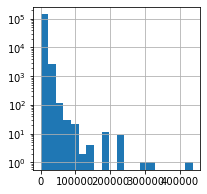

In [13]:
sm.links.loc[mask, 'length'].hist(bins=20, figsize=(3,3), log=True)

y=0.233*x+1.468


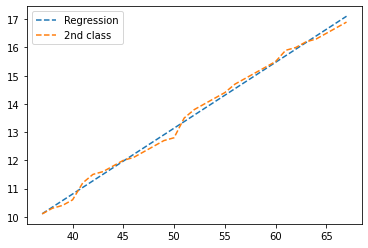

In [14]:
# Use second class single trip prices
# Choose a fit for a distance range up to 60 km (longer links are rare)
z = np.polyfit(c.loc[0:30, 'km'], c.loc[0:30, 'single_trip_second_class'], deg=1)
p = np.poly1d(z)
plt.plot(c.loc[0:30, 'km'], p(c.loc[0:30, 'km']), linestyle='--', marker=' ', label='Regression')
plt.plot(c.loc[0:30, 'km'], c.loc[0:30, 'single_trip_second_class'], linestyle='--', marker=' ', label='2nd class')
plt.legend()
print('y={}*x+{}'.format(np.round(z[0], 3), np.round(z[1], 3)))

In [15]:
# Apply the slope to links
sm.links.loc[mask, 'price'] = sm.links.loc[mask, 'length'].apply(lambda d: d*0.233/1000)

In [16]:
# Sum link cost
price_dict = sm.links.loc[mask, 'price'].to_dict()
sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'price'] = \
    sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'link_path'].apply(
        lambda l: sum([price_dict[link] if type_dict[link]=='rail_short' else 0
                       for link in l]))

In [17]:
# Add the intercept
sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'price'] += 1.468

In [18]:
# Add a price floor for short-distance rail (and cap for consistency)
sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'price'] = np.clip(
    sm.pt_los.loc[sm.pt_los['route_type']=='rail_short', 'price'], 5, 42)

In [19]:
# Add abonements share for short-distance rail
mask = (sm.pt_los['route_type']=='rail_short') & (sm.pt_los['length']<50000)
sm.pt_los.loc[mask, 'price'] = sm.pt_los.loc[mask, 'price'] / 2

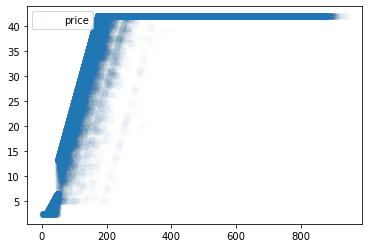

In [20]:
x = sm.pt_los.loc[sm.pt_los['route_type']=='rail_short']['length'] / 1000
y = sm.pt_los.loc[sm.pt_los['route_type']=='rail_short']['price']
plt.scatter(x, y, marker='o', alpha=.01, label='price')
plt.legend()

In [21]:
len(sm.pt_los.loc[(sm.pt_los['route_type']=='rail_short') & (sm.pt_los['price']<5)])

2805

### Rail long distance

Long-distance services have a complicated price structure that is not published by DB. Thus, we need to make assumptions based on a regression analysis of observation data (see prep32):

* Rail transport is purely path-distance and -duration-dependent
* Price dependency is linear
* There is a price cap of 139 EUR
* Assume 50/50 distribution of Sparpreis and Flexpreis

In [22]:
# Apply the slope to links
mask = sm.links['route_type']=='rail_long'
sm.links.loc[mask, 'price'] = [d*(0.01289186+0.0706054)/2/1000 + t*(6.3723344+7.73982175)/2/3600
    for d,t in zip(sm.links.loc[mask, 'length'], sm.links.loc[mask, 'time'])]

In [23]:
# Sum link cost
price_dict = sm.links.loc[mask, 'price'].to_dict()
sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'price'] = \
    sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'link_path'].apply(
        lambda l: sum([price_dict[link] if type_dict[link]=='rail_long' else 0
                       for link in l]))

In [24]:
# Add an intercept
sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'price'] += (4.66+20.23)/2

In [25]:
# Add a price cap and floor for long-distance rail
sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'price'] = np.clip(
    sm.pt_los.loc[sm.pt_los['route_type']=='rail_long', 'price'], 19, 139)

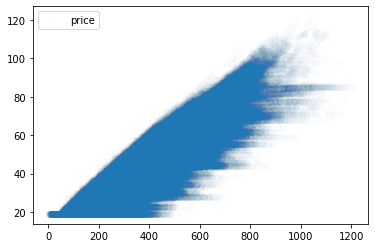

In [26]:
x = sm.pt_los.loc[sm.pt_los['route_type']=='rail_long']['length'] / 1000
y = sm.pt_los.loc[sm.pt_los['route_type']=='rail_long']['price']
plt.scatter(x, y, marker='o', alpha=.01, label='price')
plt.legend()

### Coach

Assume a linear cost function based on distance. There are several sample studies available:
* Average cost in Germany (0.107 EUR/pkm): https://de.statista.com/statistik/daten/studie/380601/umfrage/kilometerpreise-fernbuslinien-in-deutschland/
* Average cost on selected OD pairs with cheapest prices: https://www.fernbusse.de/aktuelles/studie-fernbuspreise-steigen-leicht-bahntickets-guenstiger-1628/

The latter is more realistic

In [27]:
# Load list of OD pair cost
c = pd.read_excel(input_path + 'level_of_service/coach_prices_2017.xls')
c.head(3)

,origin,origin_name,destination,destination_name,average_price,lowest_price,average_price_pkm
0,DE300,Berlin,DE712,Frankfurt,29.31,22.0,0.053
1,DE300,Berlin,DE600,Hamburg,14.33,7.9,0.050
2,DE300,Berlin,DEA23,Köln,22.61,14.9,0.039


In [28]:
# Compute average of average pkm cost
av = c['average_price_pkm'].astype(float).mean()
av

0.056600000000000004

In [29]:
sm.links.loc[sm.links['route_type']=='coach', 'price'] = \
    sm.links['length'] / 1000 * av

In [30]:
# Sum up prices in LoS table based on link fares
price_dict = sm.links['price'].to_dict()
sm.pt_los.loc[sm.pt_los['route_type']=='coach', 'price'] = \
    sm.pt_los.loc[sm.pt_los['route_type']=='coach', 'link_path'].apply(
        lambda l: sum([price_dict[link] if type_dict[link]=='coach' else 0
                       for link in l]))

In [31]:
# Add a price cap and floor
sm.pt_los.loc[sm.pt_los['route_type']=='coach', 'price'] = np.clip(
    sm.pt_los.loc[sm.pt_los['route_type']=='coach', 'price'], 5, 60)

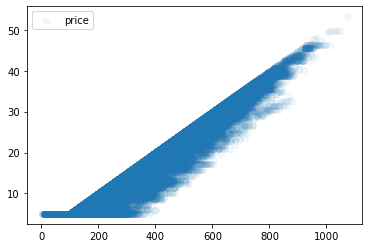

In [32]:
x = sm.pt_los.loc[sm.pt_los['route_type']=='coach']['length'] / 1000
y = sm.pt_los.loc[sm.pt_los['route_type']=='coach']['price']
plt.scatter(x, y, marker='o', alpha=.05, label='price')
plt.legend()

### Air

Match air links with prices from an online search in Sept. 2020

Average economy price: 94.30434782608695 EUR
Average business price: 275.82608695652175 EUR


<AxesSubplot:xlabel='time'>

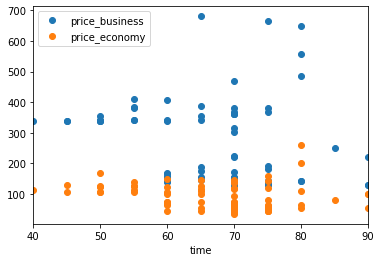

In [33]:
# Load connection list
air = pd.read_excel(input_path + 'public_transport/air_connections_germany.xls', engine='xlrd')
air = air.loc[air['direct']==True]
air['a'] = air['origin'].str[:3]
air['b'] = air['destination'].str[:3]
print('Average economy price: {} EUR'.format(air['price_economy'].mean()))
print('Average business price: {} EUR'.format(air['price_business'].mean()))
air[['price_business', 'price_economy', 'time']].set_index('time').plot(linestyle=' ', marker='o')

In [34]:
# Correct air time if neccessary
if sm.links.loc[sm.links['route_type']=='air', 'time'].mean() < 5*60:
    # Convert time to seconds
    sm.links.loc[sm.links['route_type']=='air', 'time'] = \
        sm.links.loc[sm.links['route_type']=='air', 'time'] * 60

In [35]:
# Air trips
# Take the economy price because its share is higher
# than 90% within Germany
air['trip'] = air['a'] + '-' + air['b']
price_dict = air.set_index('trip')['price_economy'].to_dict()
sm.links.loc[sm.links['route_type']=='air', 'price'] = \
    sm.links.loc[sm.links['route_type']=='air', 'trip_id'].map(price_dict)
print(len(sm.links.loc[(sm.links['route_type']=='air') & (sm.links['price'].isna())]))
sm.links.loc[sm.links['route_type']=='air'].sample(3)

0


,route_type,geometry,a,b,link_sequence,route_id,time,trip_id,length,price
index,,,,,,,,,,
air_31,air,"LINESTRING (8.57056 50.03333, 9.22196 48.68990)",FRA,STR,1,air_31,2400,FRA-STR,156652,113.0
air_46,air,"LINESTRING (11.78610 48.35380, 9.98823 53.63040)",MUC,HAM,1,air_46,5400,MUC-HAM,600019,53.0
air_22,air,"LINESTRING (7.61224 51.51830, 11.78610 48.35380)",DTM,MUC,1,air_22,4200,DTM-MUC,461421,43.0


In [36]:
# Sum up prices in LoS table based on link fares
price_dict = sm.links['price'].to_dict()
sm.pt_los.loc[sm.pt_los['route_type']=='air', 'price'] = \
    sm.pt_los.loc[sm.pt_los['route_type']=='air', 'link_path'].apply(
        lambda l: sum([price_dict[link] if type_dict[link]=='air' else 0
                       for link in l]))
sm.pt_los.loc[sm.pt_los['route_type']=='air', 'price'].mean()

90.18179679707936

In [37]:
len(sm.pt_los.loc[sm.pt_los['price'].isna()])

0

### Local transport

Local transport fares are added on top, as they are usually included into the rail ticket price or have a standalone price map dependent on ordinal distance classes.

In [38]:
# Add a fare for local transport services
# Get links with bus service at start or end of the trip
mode_dict = sm.links['route_type'].to_dict()
bus_at_o = sm.pt_los['link_path'].apply(lambda l: mode_dict[l[0]]=='bus' if len(l)>0 else False)
bus_at_d = sm.pt_los['link_path'].apply(lambda l: mode_dict[l[-1]]=='bus' if len(l)>0 else False)
only_bus = sm.pt_los['route_type']=='bus'
# Bus tickets are included in long-distance rail tickets
rail_long = sm.pt_los['route_types'].apply(lambda t: 'rail_long' in t)
# Define price structure by regional type
# Average value from ADAC for cities: https://www.adac.de/reise-freizeit/ratgeber/tests/oepnv-preise-vergleich/
region_dict = sm.zones['urbanisation'].to_dict()
region_prices = {1: 2.74, 2: 4, 3: 4}

# Case 1: Multimodal
sm.pt_los.loc[(bus_at_o) & ~(only_bus) & ~(rail_long), 'price'] += sm.pt_los.loc[
    (bus_at_o) & ~(only_bus) & ~(rail_long), 'origin'].map(region_dict).map(region_prices)
sm.pt_los.loc[(bus_at_d) & ~(only_bus) & ~(rail_long), 'price'] += sm.pt_los.loc[
    (bus_at_d) & ~(only_bus) & ~(rail_long), 'destination'].map(region_dict).map(region_prices)

# Case 2: Only bus
sm.pt_los.loc[only_bus, 'price'] = [
    region_prices[max(region_dict[o], region_dict[d])]
    for o,d in zip(sm.pt_los.loc[only_bus, 'origin'], sm.pt_los.loc[only_bus, 'destination'])]

In [39]:
len(sm.pt_los.loc[sm.pt_los['price'].isna()])

0

In [40]:
sm.pt_los.groupby('route_type').agg(
    {'time': 'mean', 'price': 'mean', 'length': 'mean', 'ntransfers': 'mean'})

,time,price,length,ntransfers
route_type,,,,
air,21201.036649,91.338007,605338.497300,4.663675
bus,8881.264933,3.915330,45134.359166,2.575180
coach,25134.396335,21.099357,373577.030348,3.201598
rail_long,19610.746876,48.325336,425250.821107,2.639766
rail_short,21819.750456,40.036741,348746.352363,3.215915
walk,8.029777,0.000000,0.000000,0.000000


## Accessibility

In [41]:
def accessibility(dist_origin, dist_destination, weight=20):
    '''calculate an accessibility metric based on distances
    :param dist_origin: distance to the next mean of transport from origin in km
    :param dist_destination: distance from the used mean of transport to destination in km
    :param weight: (optional) weight of distance values
    :return: accessibility factor on a range from 0 to 1'''
    return max(0, 1 - dist_origin/weight - dist_destination/weight)

In [42]:
# Take average weighted distances to the next PT stop
# They were computed in prep16 from census data
clusters = pd.read_csv('../input/spatial_census_refined.csv')
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
#pop_col = 'population'
# Convert to km
clusters[mean_dist_col] = clusters[mean_dist_col] / 1000

In [43]:
type_dict = {'rail_short_distance': 'rail_short', 'rail_long_distance': 'rail_long'}
clusters['route_type'].replace(type_dict, inplace=True)
zone = 'NUTS_ID' if 'NUTS_ID' in clusters.columns else 'FID'
mean_w_dist_dict = clusters.groupby(
    [zone, 'route_type']).agg(
    {mean_dist_col: 'mean'}).to_dict()[mean_dist_col]

In [44]:
# The accessibility is a metric from the mean weighted distance in km
sm.pt_los['accessibility'] = 1

In [45]:
# Divide into PT and all walk
walk = sm.pt_los.loc[sm.pt_los['link_path'].apply(lambda l: len(l)==0)]
pt = sm.pt_los.loc[sm.pt_los['link_path'].apply(lambda l: len(l)>0)]

In [46]:
link_type = sm.links['route_type'].to_dict()
def get_accessibility(o, d, l_path, weight=20):
    try:
        return accessibility(mean_w_dist_dict[o, link_type[l_path[0]]],
                             mean_w_dist_dict[d, link_type[l_path[-1]]],
                             weight)
    except KeyError:
        # No such type in this region
        return 0

In [47]:
pt['accessibility'] = [get_accessibility(*a) for a in tuple(
    zip(pt['origin'], pt['destination'], pt['link_path'])#, [30 for _ in range(len(pt))])
)]

In [48]:
pt.groupby('route_type').agg(
    {'accessibility': 'mean', 'origin': 'count'})

,accessibility,origin
route_type,,
air,0.512512,106278
bus,0.680187,3884
coach,0.565272,114108
rail_long,0.494034,310504
rail_short,0.550277,196170


route_type
air           [[AxesSubplot(0.125,0.125;0.775x0.755)]]
bus           [[AxesSubplot(0.125,0.125;0.775x0.755)]]
coach         [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_long     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_short    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

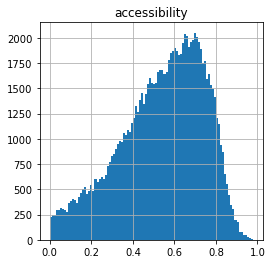

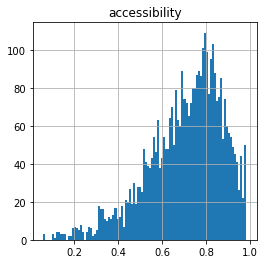

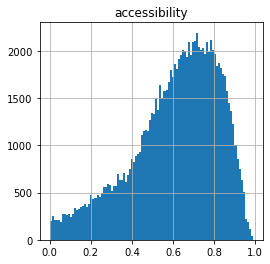

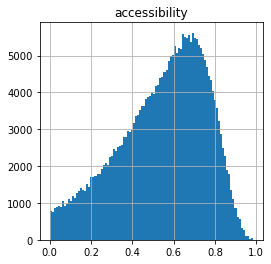

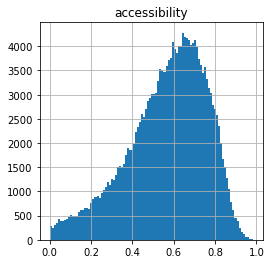

In [49]:
# The accessibility does not depend on the
# route_type columns of pt_los, but on the link path
pt.loc[pt['accessibility']>0].groupby('route_type').hist(
    column='accessibility', bins=100, figsize=(4,4), log=False)

In [50]:
sm.pt_los = pt.append(walk)

## Save

In [51]:
print(sm.pt_los.columns)
print(sm.pt_los.shape)
sm.pt_los.sample()

Index(['origin', 'destination', 'route_types', 'link_path', 'ntransfers',
       'length', 'access_time', 'footpath_time', 'in_vehicle_time',
       'waiting_time', 'time', 'route_type', 'price', 'accessibility'],
      dtype='object')
(731347, 14)


,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,time,route_type,price,accessibility
index,,,,,,,,,,,,,,
293847,DE715,DE403,"[bus, coach]","[bus_1368860, bus_1368862, bus_1368863, coach_...",2,663578,1337,496,24202,1725,27761,coach,36.910636,0.877506


In [52]:
sm.to_json(model_path + 'de_pt_los',
           only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:11<00:00,  3.08it/s]


In [53]:
'''# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'length', 'headway', 'price']
if 'route_type_disagg' in sm.links.columns: cols.append('route_type_disagg')
if 'boarding_time' in sm.links.columns: cols.append('boarding_time')
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)
sm.to_json(model_path + 'de_pt_network_agg', only_attributes=[
    'zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')'''
print('Not neccessary to save')

Not neccessary to save
